<a href="https://www.kaggle.com/code/yaaangzhou/pg-s3-e24-eda-modeling-ensemle-nn?scriptVersionId=147769363" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Created by Yang Zhou**

**[PLAYGROUND S-3,E-24]📊EDA + Modeling📈**

**24 Oct 2023**

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Binary Prediction of Smoker Status using Bio-Signals
</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Playground Series - Season 3, Episode 24</center></p>

***

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Insights and Tricks</center>



**Key Observation:**


# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Version Detail</center>
| Version | Description | Best Public Score |
|---------|-------------|-----------------|
| Version 1 | Autogluon Baseline |  |

# 0. Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import math
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, train_test_split, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE, RFECV

# Models
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna

# NN
import torch
import torch.nn as nn
import torch.optim as optim
if torch.cuda.is_available():
    device = torch.device("cuda")  
else:
    device = torch.device("cpu")   
from torch.utils.data import DataLoader, TensorDataset

# Metrics 
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score, auc, confusion_matrix, classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Adjusting plot style

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# 1. Load Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e24/sample_submission.csv')

# Drop column id
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

total = pd.concat([train, test], ignore_index=True)
# total = pd.concat([train, test], ignore_index=True)

print('The shape of the train data:', train.shape)
print('The shape of the test data:', test.shape)

print('The shape of the total data:', total.shape)

The shape of the train data: (159256, 23)
The shape of the test data: (106171, 22)
The shape of the total data: (265427, 23)


In [4]:
total.head(3)

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1.0
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0.0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1.0


In [5]:
target = 'smoking'

full_features = test.columns
num_var = [column for column in train.columns if train[column].nunique() > 10]

# 2. EDA

In [6]:
train.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
age,159256.000000,44.306626,11.842286,20.000000,40.000000,40.000000,55.000000,85.000000
height(cm),159256.000000,165.266929,8.818970,135.000000,160.000000,165.000000,170.000000,190.000000
weight(kg),159256.000000,67.143662,12.586198,30.000000,60.000000,65.000000,75.000000,130.000000
waist(cm),159256.000000,83.001990,8.957937,51.000000,77.000000,83.000000,89.000000,127.000000
eyesight(left),159256.000000,1.005798,0.402113,0.100000,0.800000,1.000000,1.200000,9.900000
eyesight(right),159256.000000,1.000989,0.392299,0.100000,0.800000,1.000000,1.200000,9.900000
hearing(left),159256.000000,1.023974,0.152969,1.000000,1.000000,1.000000,1.000000,2.000000
hearing(right),159256.000000,1.023421,0.151238,1.000000,1.000000,1.000000,1.000000,2.000000
systolic,159256.000000,122.503648,12.729315,77.000000,114.000000,121.000000,130.000000,213.000000
relaxation,159256.000000,76.874071,8.994642,44.000000,70.000000,78.000000,82.000000,133.000000


In [7]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum())/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    return sum

summary(total).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
age,int64,0,0.000000,21,265427
height(cm),int64,0,0.000000,18,265427
weight(kg),int64,0,0.000000,32,265427
waist(cm),float64,0,0.000000,541,265427
eyesight(left),float64,0,0.000000,21,265427
eyesight(right),float64,0,0.000000,19,265427
hearing(left),int64,0,0.000000,2,265427
hearing(right),int64,0,0.000000,2,265427
systolic,int64,0,0.000000,120,265427
relaxation,int64,0,0.000000,81,265427


In [8]:
summary(test).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
age,int64,0,0.000000,18,106171
height(cm),int64,0,0.000000,16,106171
weight(kg),int64,0,0.000000,26,106171
waist(cm),float64,0,0.000000,508,106171
eyesight(left),float64,0,0.000000,20,106171
eyesight(right),float64,0,0.000000,18,106171
hearing(left),int64,0,0.000000,2,106171
hearing(right),int64,0,0.000000,2,106171
systolic,int64,0,0.000000,114,106171
relaxation,int64,0,0.000000,78,106171


## Correlation

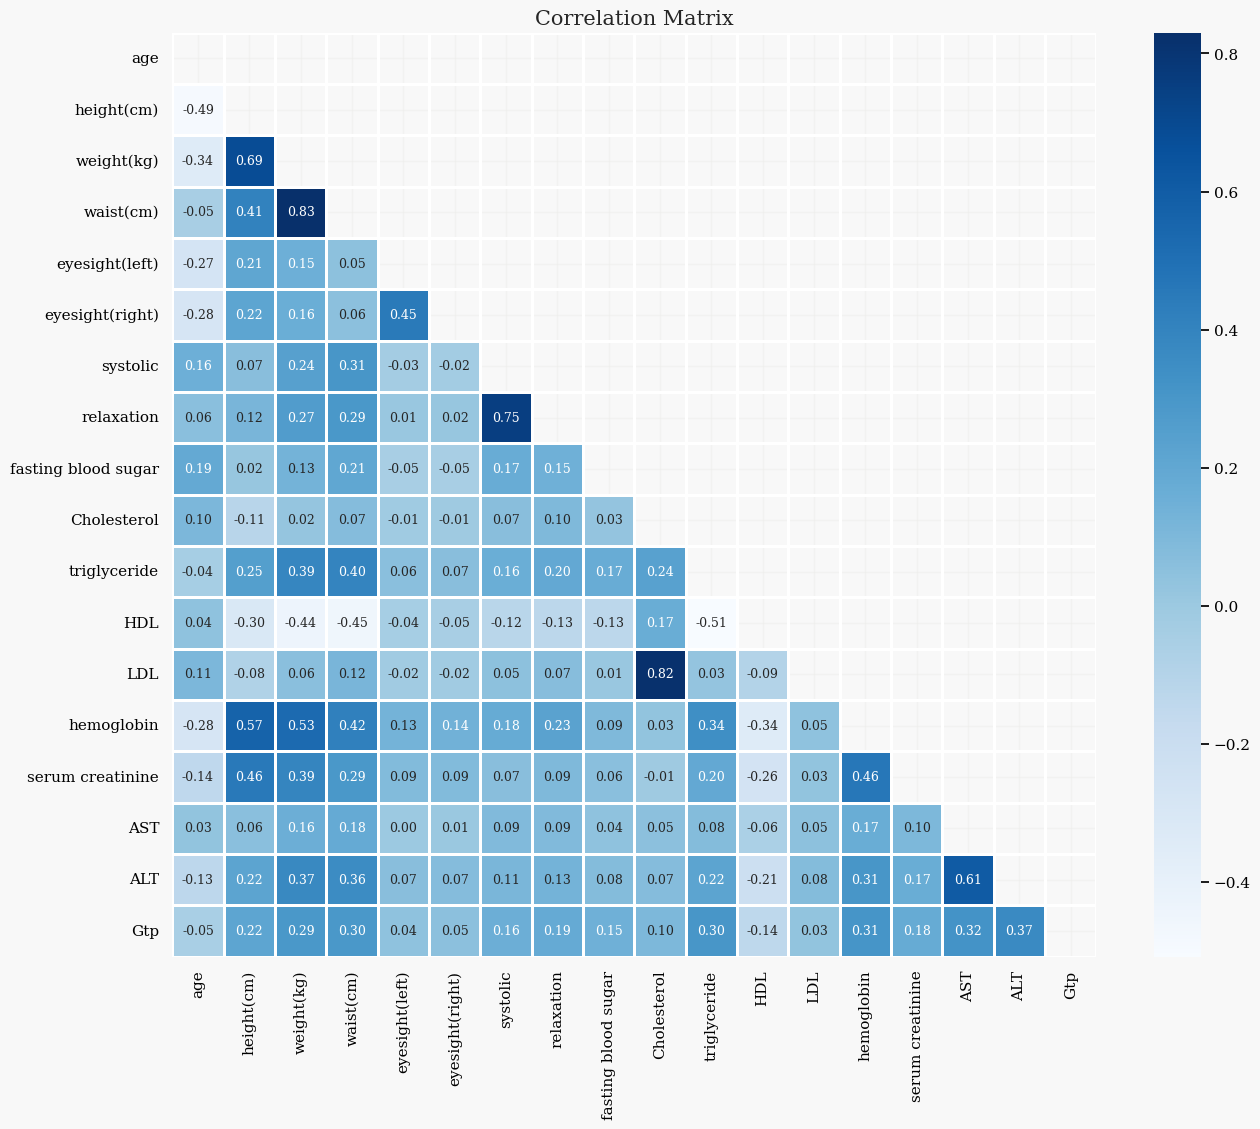

In [9]:
corr_matrix = total[num_var].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

## Scatterplot of highly correlated variables

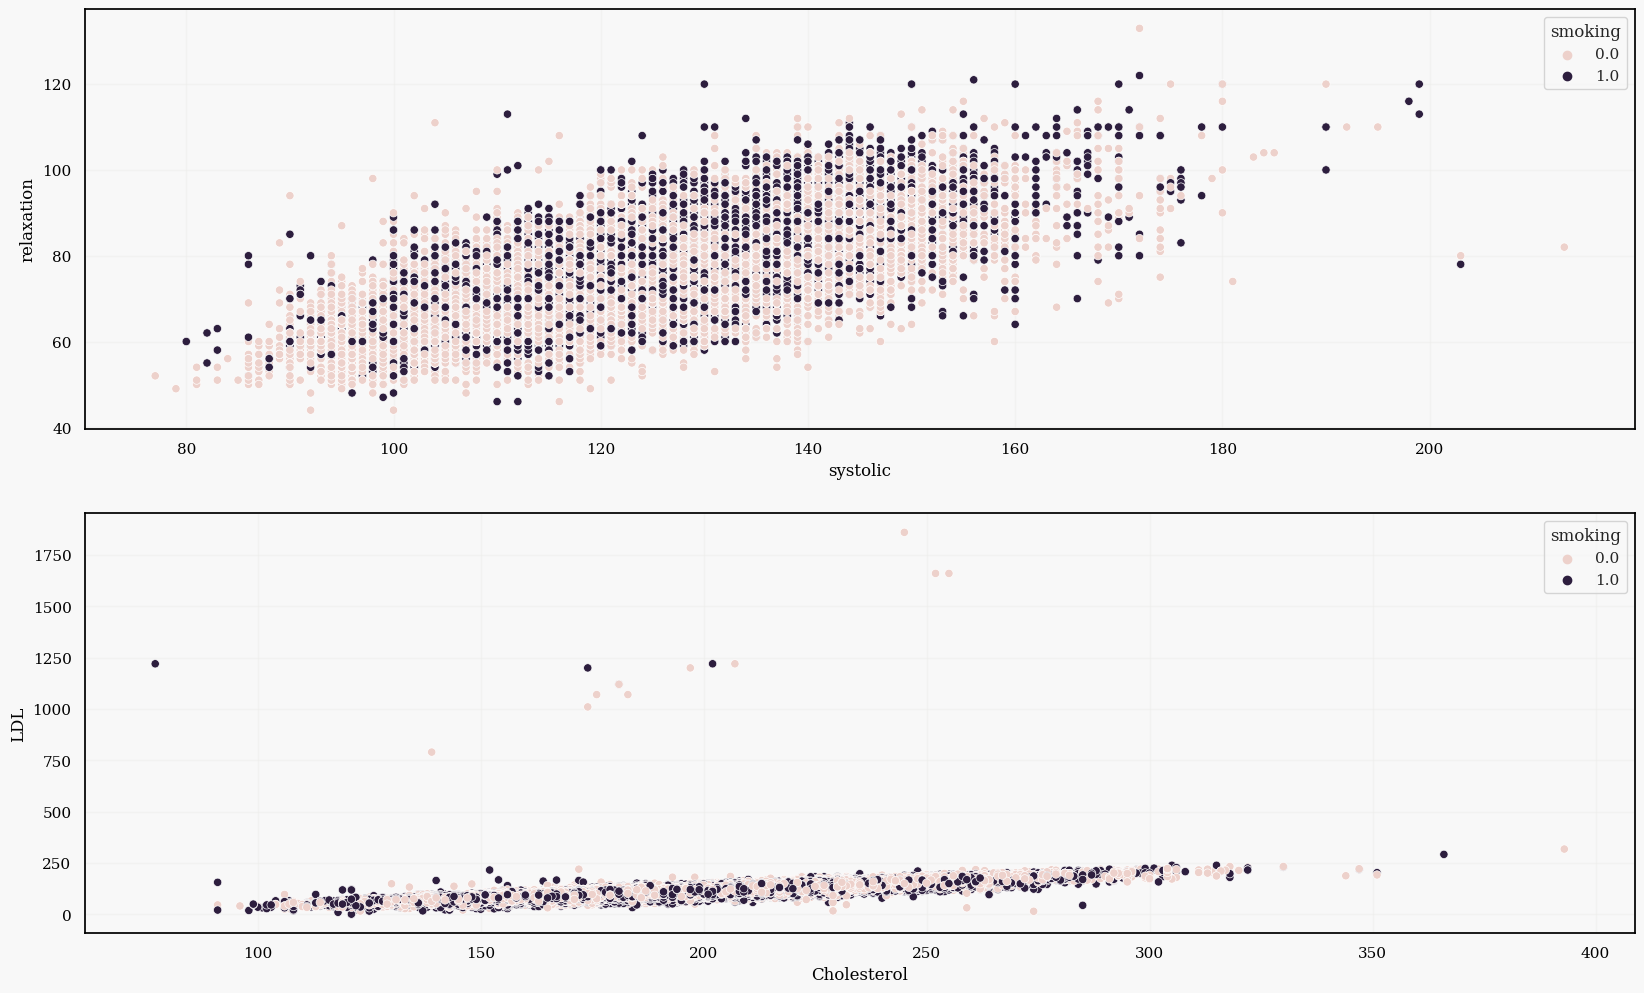

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

sns.scatterplot(ax=axes[0], data=total, x='systolic', y='relaxation', hue=target)
sns.scatterplot(ax=axes[1], data=total, x='Cholesterol', y='LDL', hue=target)

plt.show()

## Distribution of Target

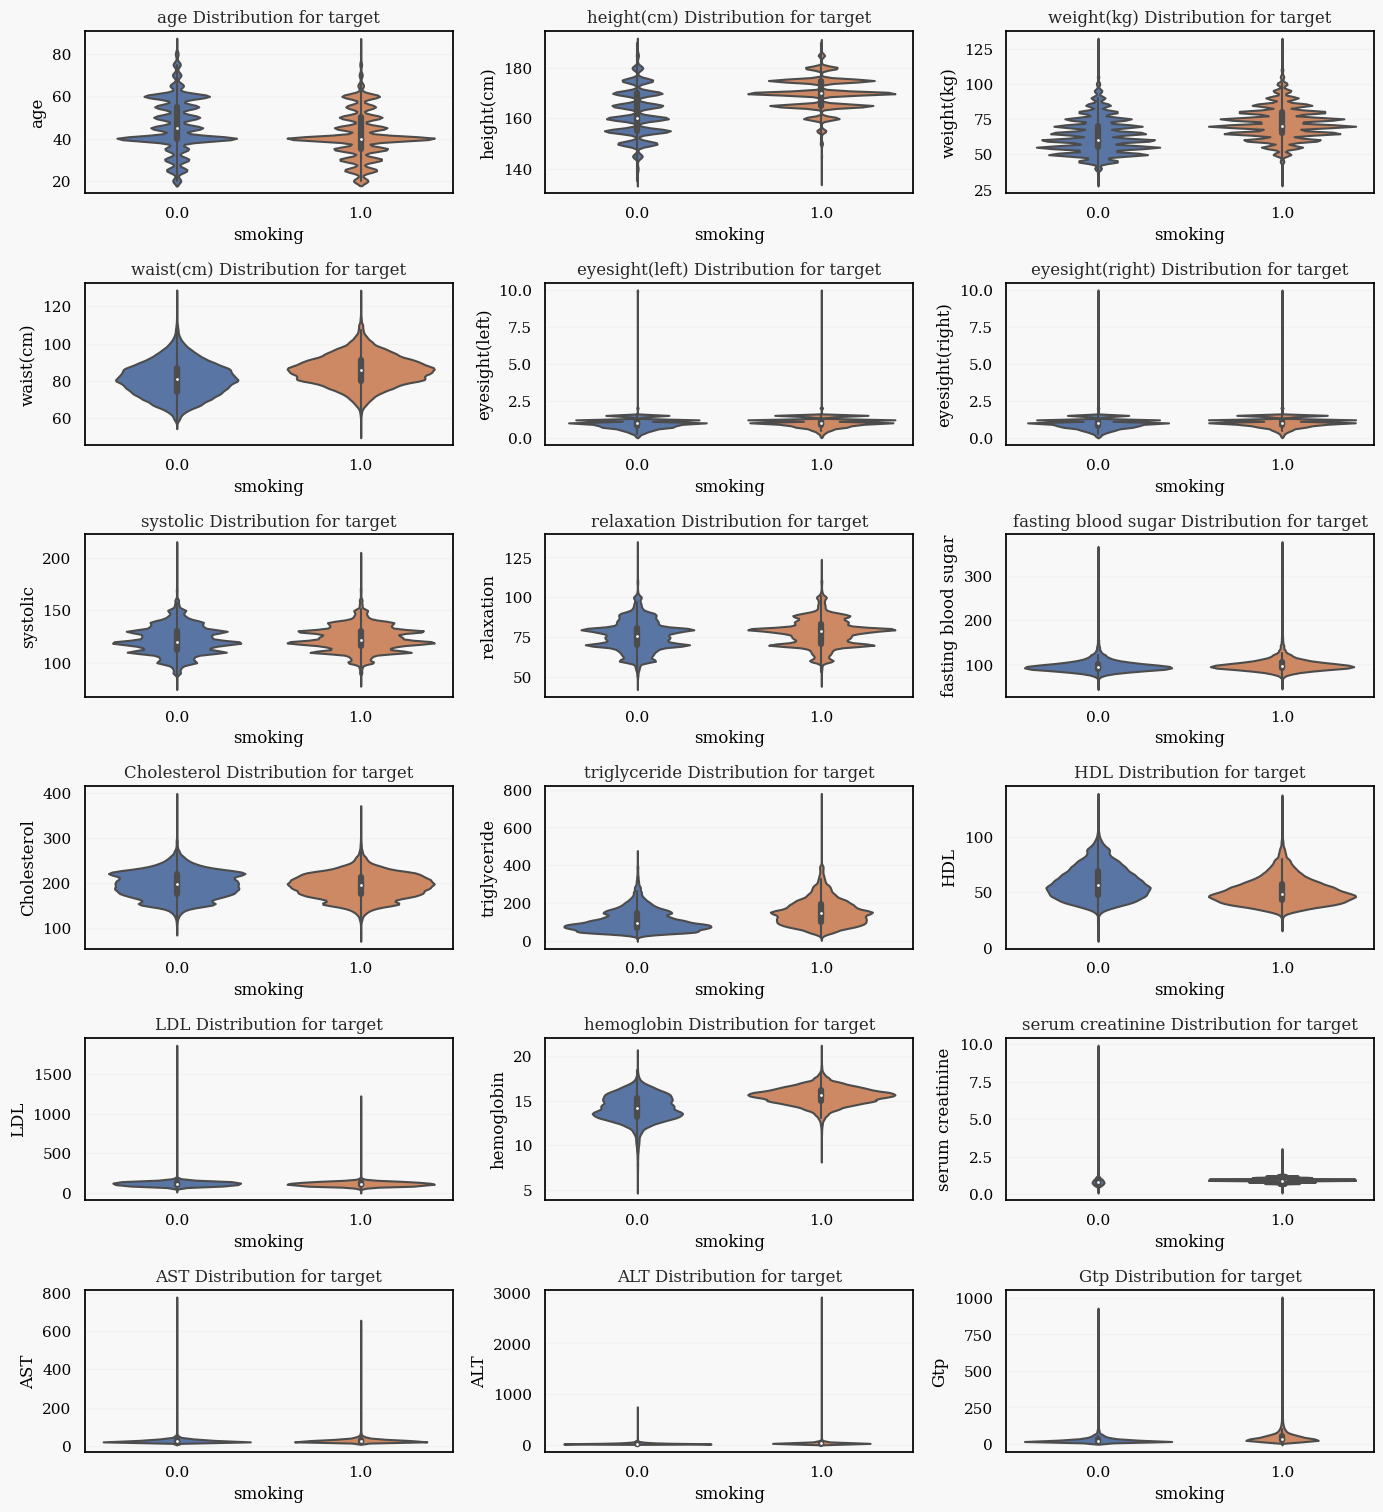

In [11]:
num_rows = len(num_var)
num_cols = 3 

total_plots = num_rows * num_cols
plt.figure(figsize=(14, num_rows * 2.5))

for idx, col in enumerate(num_var):
    plt.subplot(num_rows, num_cols, idx % total_plots + 1)
    sns.violinplot(x=target, y=col, data=total)
    plt.title(f"{col} Distribution for target")

plt.tight_layout()
plt.show()

## Distribution of Numeric Variables in Train/Test set

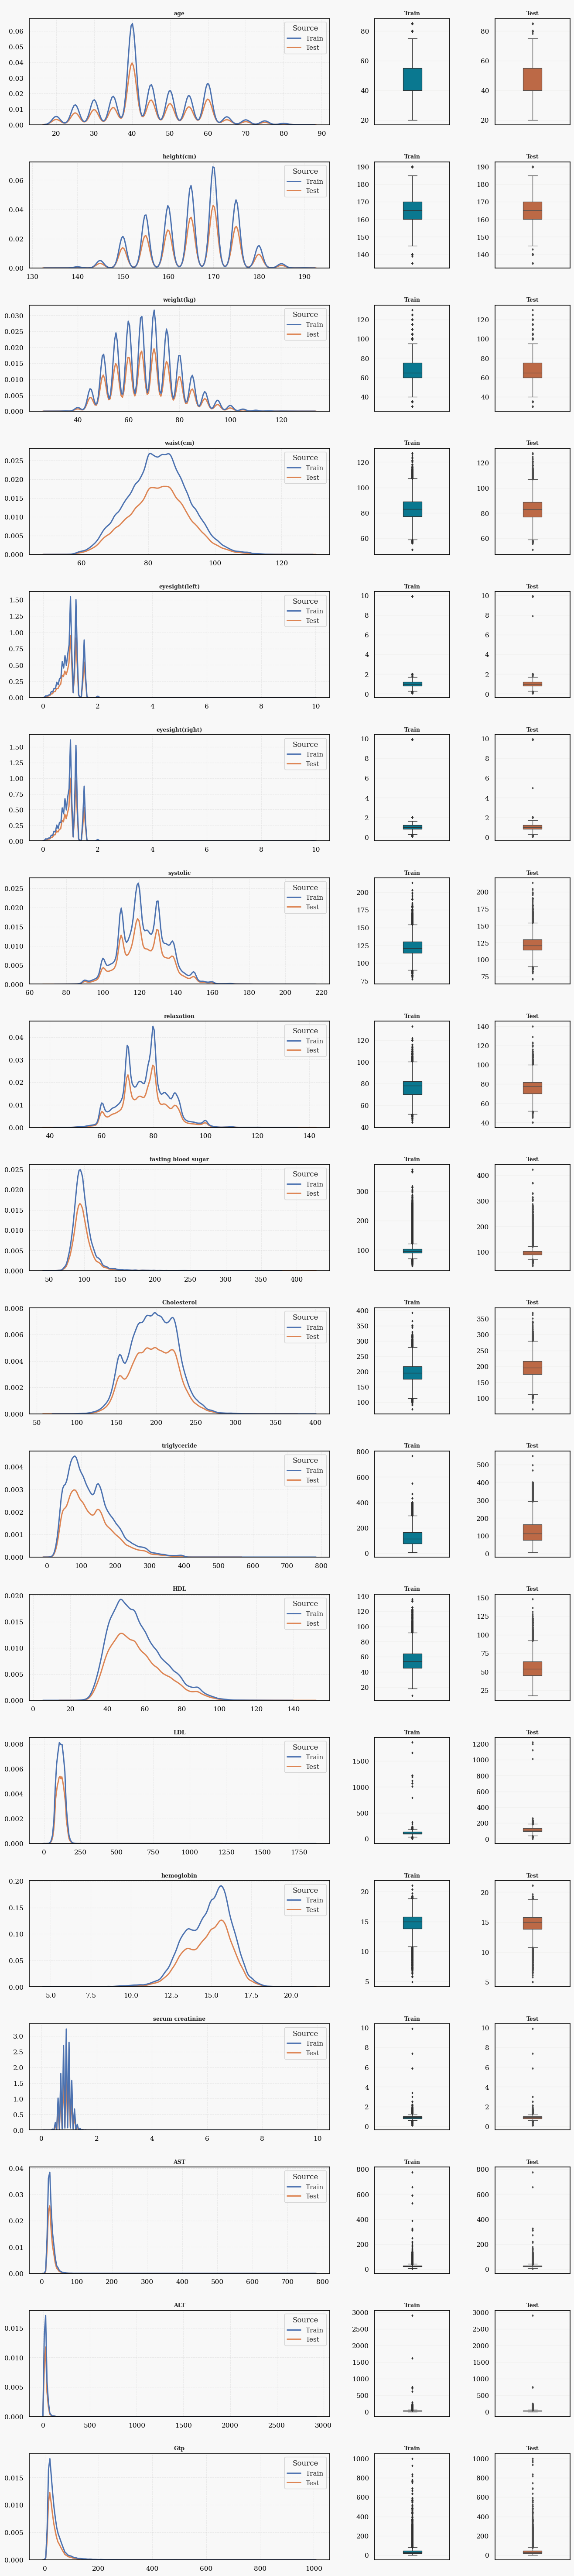

In [12]:
df = pd.concat([train[num_var].assign(Source = 'Train'), 
                test[num_var].assign(Source = 'Test')], 
               axis=0, ignore_index = True);

fig, axes = plt.subplots(len(num_var), 3 ,figsize = (16, len(num_var) * 4.2), 
                         gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]});

for i,col in enumerate(num_var):
    ax = axes[i,0];
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', ax = ax, linewidth = 2.1)
    ax.set_title(f"\n{col}",fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');
    ax = axes[i,1];
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,saturation = 0.90, linewidth = 0.90, fliersize= 2.25, color = '#037d97',
                ax = ax);
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Train",fontsize = 9, fontweight= 'bold');

    ax = axes[i,2];
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                saturation = 0.6, linewidth = 0.90, color = '#E4591E',
                ax = ax); 
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Test",fontsize = 9, fontweight= 'bold');

plt.tight_layout();
plt.show();

In [13]:
df_train = total[total[target].notna()]

df_test = total[total[target].isna()]
df_test.drop(target,axis=1,inplace=True)

In [14]:
df_train

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1.0
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0.0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1.0
3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0.0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,64,238,47,72,159,14.5,1,0.8,25,26,13,0,0.0
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,89,213,202,64,108,14.5,1,0.6,21,20,18,0,0.0
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,84,189,45,87,93,10.9,1,0.6,15,9,12,0,0.0
159254,50,165,75,92.0,1.2,1.0,1,1,121,90,122,165,148,55,80,14.4,1,1.1,22,17,37,0,1.0


# 3. Features Engineering

## Baseline Model

In [15]:
lgbm_baseline = LGBMClassifier(n_estimators=1000,
                     max_depth=10,
                     random_state=42)

roc_results = pd.DataFrame(columns=['Selected_Features', 'ROC'])

def evaluation(df, select_features, note):
    global roc_results
    
    X = df[select_features]
    Y = df[target]
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    roc_scores = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]
        
        lgbm_baseline.fit(X_train, y_train)
        y_hat = lgbm_baseline.predict_proba(X_test)[:, 1] 
        roc = roc_auc_score(y_test, y_hat)
        roc_scores.append(roc)
    
    average_roc = np.mean(roc_scores)
    new_row = {'Selected_Features': note, 'ROC': average_roc}
    roc_results = pd.concat([roc_results, pd.DataFrame([new_row])], ignore_index=True)

    print('====================================')
    print(note)
    print("Average ROC:", average_roc)
    print('====================================')
    return average_roc

In [16]:
evaluation(df=df_train,select_features=full_features,note='Baseline')

Baseline
Average ROC: 0.8652818663537611


0.8652818663537611

## Features Importance

In [17]:
def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title(f'Feature importances', size=16, y=1.05, 
              fontweight='bold')
    a = sns.barplot(data=f_imp, x='imp', y='feature', linestyle="-", 
                    linewidth=0.5, edgecolor="black",palette='GnBu')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11)
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()

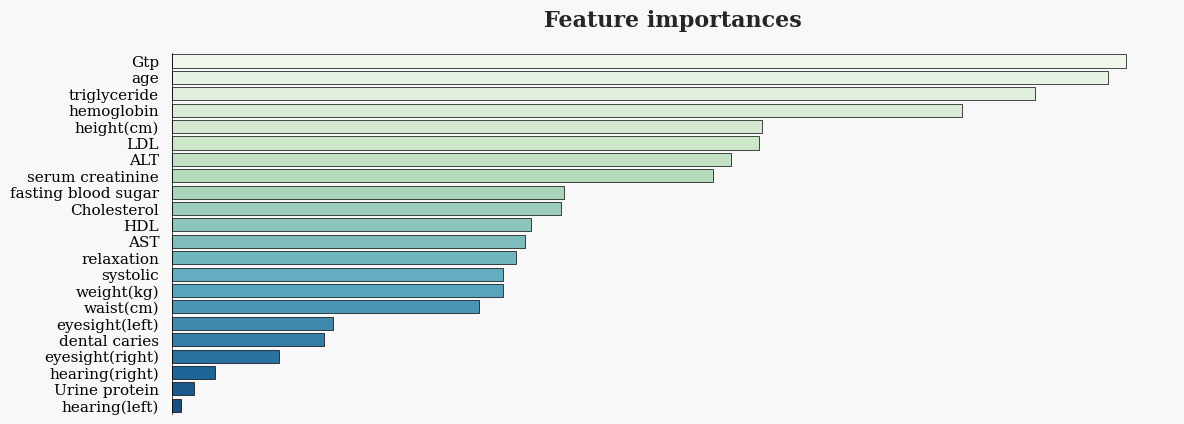

In [18]:
clf = LGBMClassifier()
clf.fit(df_train.drop(target,axis=1), df_train[target])

f_imp_df = pd.DataFrame({'feature': df_train.drop(target,axis=1).columns, 'imp': clf.feature_importances_})
f_imp_df.sort_values(by='imp',ascending=False,inplace=True)
f_importance_plot(f_imp_df)

## Features Selection: RFECV

In [19]:
clf = LGBMClassifier()
rfe = RFECV(clf)
X_rfe = rfe.fit_transform(df_train.drop(target,axis=1), df_train[target])
clf.fit(X_rfe,df_train[target])

cols = list(df_train.drop(target,axis=1).columns)
temp = pd.Series(rfe.support_,index = cols)
featureRFE = temp[temp==True].index.tolist()

In [20]:
print(featureRFE)

['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']


In [21]:
evaluation(df=df_train,select_features=featureRFE,note='Feature RFE')

Feature RFE
Average ROC: 0.8650708229153959


0.8650708229153959

# 4. Modeling

# 5. Hyperparameter optimization of individual models

# 6. NN by pytorch

# 7. Autogluon Baseline

In [22]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.7/285.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.3/372.3 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 17.6 MB/s e

In [23]:
from autogluon.tabular import TabularDataset, TabularPredictor

predictor = TabularPredictor(label=target,).fit(df_train)

No path specified. Models will be saved in: "AutogluonModels/ag-20231024_023642/"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231024_023642/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Oct 13 11:53:00 UTC 2023
Disk Space Avail:   20.94 GB / 20.96 GB (99.9%)
Train Data Rows:    159256
Train Data Columns: 22
Label Column: smoking
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, 0.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['bina

In [24]:
preds = predictor.predict_proba(df_test)
auto_submission = sample_submission.copy()
auto_submission['smoking'] = preds[1].values

In [25]:
auto_submission.to_csv('auto_submission.csv',index=False)
auto_submission.head()

,id,smoking
0,159256,0.615866
1,159257,0.247830
2,159258,0.531535
3,159259,0.101679
4,159260,0.534488
